<a href="https://colab.research.google.com/github/bitblayde/Machine-and-Deep-learning-projects/blob/main/NLP/automata/reber_language.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


This exercise attempts to resolve the exercise 16.8 from the Hands-on ML book.


In [1]:
import numpy as np

reber_grammar = [ 
                 [("B", 1)],
                 [("T", 2), ("P", 3)],
                 [("S", 2), ("X", 4)],
                 [("T", 3), ("V", 5)],
                 [("X", 3), ("S", 6)],
                 [("P", 4), ("V", 6)],
                 [("E", None)]
]

embedded_reber_grammar = [
                    [("B", 1)],
                    [("T", 2), ("P", 3)],  
                    [(reber_grammar, 4)],    
                    [(reber_grammar, 5)],
                    [("T", 6)],
                    [("P", 6)],
                    [("E", None)]
]

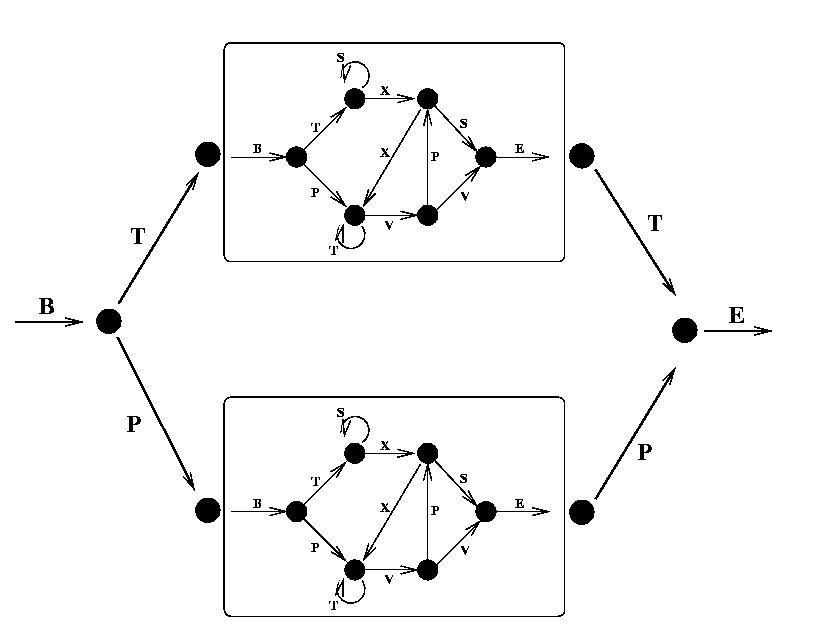

Image extracted from https://www.willamette.edu/~gorr/classes/cs449/reber.html

In [2]:
def generate_reber_grammar(grammar):
  output = []
  state = 0

  while state is not None:
    index = np.random.randint(len(grammar[state]))

    node, state = grammar[state][index]

    if isinstance(node, list):
      node = generate_reber_grammar(node)

    output.append(node)

  return "".join(output)


np.random.seed(42)

for _ in range(10):
  print(generate_reber_grammar(embedded_reber_grammar), end=" ")

BTBPTTTVPXTVPXTTVPSETE BPBPTVPSEPE BPBPVVEPE BPBPVPXVVEPE BPBTXXTTTTVVEPE BPBPVPSEPE BPBTXXVPSEPE BPBTSSSSSSSXSEPE BTBPVVETE BPBTXXVVEPE 

In [3]:
vocabulary = "BEPSTVX"
def generate_non_reber_grammar(grammar, vocab):
  reber_string = generate_reber_grammar(grammar)
  idx = np.random.randint(len(reber_string))
  to_change = np.random.choice( list(set(vocab) - set(reber_string[idx])) )
  non_reber_string = reber_string[:idx] + to_change + reber_string[idx+1:]
  return non_reber_string

for _ in range(10):
  print(generate_non_reber_grammar(embedded_reber_grammar, vocabulary), end=" ") 

BPSTXXVPSEPE BTBTVVETE BPBSVVEPE BXBTXSETE BPBPVPSSPE BTBPVVVETE BPBTSXSEEE BPBPTTTPTTTTTVPSEPE BTBTXXTTETVPSETE BBBTXSETE 

In [4]:
def char_to_int(gammar, vocabulary):
  return [vocabulary.index(i) for i in gammar]

In [5]:
import tensorflow as tf
def get_dataset(size, gammar, vocabulary):
  reber_grammar = [ char_to_int(generate_reber_grammar(gammar), vocabulary) for i in range(size//2) ]
  non_reber_grammar = [ char_to_int(generate_non_reber_grammar(gammar, vocabulary), vocabulary) for i in range(size - (size //2) ) ]

  dataset = reber_grammar + non_reber_grammar

  y = [[1.] for i in range(len(reber_grammar)) ] + [[0.] for i in range(len(non_reber_grammar)) ]

  return tf.ragged.constant(dataset, ragged_rank=1), np.array(y)

trainX, trainy = get_dataset(size=8000, gammar=embedded_reber_grammar, vocabulary=vocabulary)
valX, valy = get_dataset(size=int(8000*0.3), gammar=embedded_reber_grammar, vocabulary=vocabulary)

In [6]:
from tensorflow import keras

EMBEDDED_SIZE = 5

input = tf.keras.Input(shape=[None], dtype=tf.int32, ragged=True)

X = tf.keras.layers.Embedding(input_dim=len(vocabulary), output_dim=EMBEDDED_SIZE)(input)
X = tf.keras.layers.GRU(units=100, activation='tanh')(X)
output = tf.keras.layers.Dense(1, activation="sigmoid")(X)
model = keras.Model(inputs=input, outputs=output)

In [9]:
tf.keras.backend.clear_session()

optim = keras.optimizers.SGD(learning_rate=0.02, momentum=0.99, nesterov=True) # Are IID
model.compile(optimizer=optim, loss="binary_crossentropy", metrics=["accuracy"])
model.fit(trainX, trainy, epochs=15, validation_data=(valX, valy))

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/gru/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/gru/RaggedToTensor/boolean_mask/GatherV2:0", shape=(None, 5), dtype=float32), dense_shape=Tensor("gradient_tape/model/gru/RaggedToTensor/Shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


250/250 [==============================] - 15s 54ms/step - loss: 0.1874 - accuracy: 0.9434 - val_loss: 0.1894 - val_accuracy: 0.9450
Epoch 2/15
250/250 [==============================] - 13s 54ms/step - loss: 0.1704 - accuracy: 0.9477 - val_loss: 0.2124 - val_accuracy: 0.9425
Epoch 3/15
250/250 [==============================] - 13s 53ms/step - loss: 0.1607 - accuracy: 0.9540 - val_loss: 0.1620 - val_accuracy: 0.9550
Epoch 4/15
250/250 [==============================] - 14s 57ms/step - loss: 0.1471 - accuracy: 0.9574 - val_loss: 0.1271 - val_accuracy: 0.9671
Epoch 5/15
250/250 [==============================] - 14s 57ms/step - loss: 0.1381 - accuracy: 0.9615 - val_loss: 0.1254 - val_accuracy: 0.9679
Epoch 6/15
250/250 [==============================] - 14s 54ms/step - loss: 0.1367 - accuracy: 0.9631 - val_loss: 0.1134 - val_accuracy: 0.9696
Epoch 7/15
250/250 [==============================] - 14s 55ms/step - loss: 0.1201 - accuracy: 0.9681 - val_loss: 0.1345 - val_accuracy: 0.9692
Epo

In [10]:
reber_sample = ["BTBTSSXXTVVETE", "BPBPVPXVPXVPXVVEPE"]
non_reber_sample = ["BTBTSSPXSETE", "BPBPVSPSEPE"]

X_test = reber_sample + non_reber_sample

X_test_encoded = tf.ragged.constant( [char_to_int(i, vocabulary) for i in X_test], ragged_rank=1)
y_pred = model.predict(X_test_encoded)

for i in range(len(y_pred)):
    print("{}: {:.3f}%".format(X_test[i], 100 * y_pred[i][0]))

BTBTSSXXTVVETE: 98.982%
BPBPVPXVPXVPXVVEPE: 99.300%
BTBTSSPXSETE: 0.075%
BPBPVSPSEPE: 0.003%
